# GEDI
#### GEDI04_A - Level 4A Footprint Above Ground Biomass
#### [ORNL DAAC](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2056)
#### [ORNL GEDI Tutorial](https://github.com/ornldaac/gedi_tutorials)

In [1]:
import datetime as dt

#bbox = [29.269398, -1.554519, 29.482104, -1.375895] # very big area across multiple UTM zones
#bbox = [29.306425, -1.552757, 29.834540, -0.946101] # Virunga and Bwindi
bbox = [29.270558, -1.648015, 29.705426, -1.311937] # larger Virunga
#bbox = [29.379769, -0.027296, 31.069115, 1.013246] # small Virunga
start_date = dt.datetime(2021, 9, 1) 
end_date = dt.datetime(2022, 6, 1)

In [16]:
import datetime as dt
import geopandas as gpd
import pandas as pd
import rasterio
import requests
from shapely.geometry import MultiPolygon, Polygon, box, shape


# DOI: Digital Object Identifier
doi = '10.3334/ORNLDAAC/2056' # GEDI L4A DOI 

# CMR: Common Metadata Repository
cmr_url = 'https://cmr.earthdata.nasa.gov/search' 
search_url = f'{cmr_url}/collections.json?doi={doi}'

# Unique NASA-given concept ID for the GEDI 4A dataset, used to retrieve relevant files (or granules) for GEDI L4A
concept_id = requests.get(search_url).json()['feed']['entry'][0]['id']
print(concept_id)

C2237824918-ORNL_CLOUD


In [275]:
date_format = '%Y-%m-%dT%H:%M:%SZ'
date_string = start_date.strftime(date_format) + ',' + end_date.strftime(date_format)

bbox_string = ','.join(map(str, bbox)) # lng1,lat1,lng2,lat2

granules_list = []
page_size, page_num = 2000, 1

while True:    
    cmr_params = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": date_string,
        "bounding_box[]": bbox_string
    }
    
    granules_url = f'{cmr_url}/granules.json'
    granules_res = requests.get(granules_url, params=cmr_params)
    granules = granules_res.json()['feed']['entry']
        
    if granules:
        for g in granules:

            granule_url = ''
            granule_polygon = ''            
            granule_size = float(g['granule_size'])
            
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i = iter(poly[0].split(" "))
                    latlng = list(map(" ".join, zip(i, i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in latlng]))
                    
                granule_polygon = MultiPolygon(multipolygons)
            
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
                    
            granules_list.append([granule_url, granule_size, granule_polygon])
               
        page_num += 1
        
    else: 
        break

In [276]:
granules_list.append(['bound', 0, box(bbox[0], bbox[1], bbox[2], bbox[3])]) # for plotting
gedi_df = pd.DataFrame(granules_list, columns=["granule_url", "granule_size", "granule_polygon"])
gedi_df = gedi_df[gedi_df['granule_polygon'] != '']

print("Total granules found:", len(gedi_df.index)-1)
print("Total file size (MB): %0.2f" % gedi_df['granule_size'].sum())

Total granules found: 8
Total file size (MB): 1399.12


(-2.554519, -0.3758950000000001)

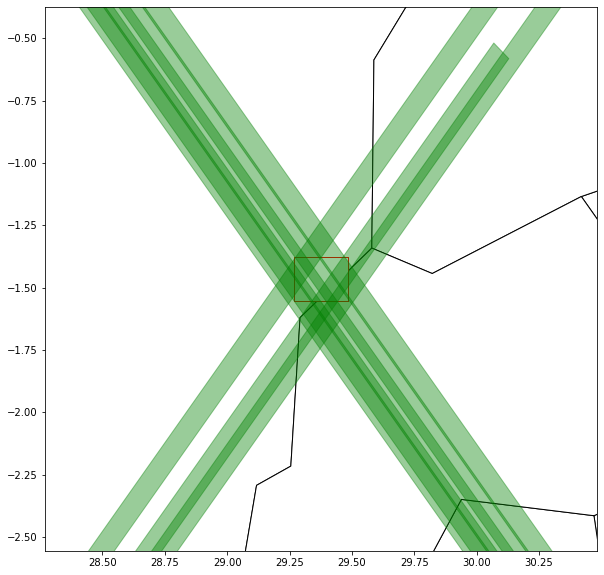

In [277]:
gdf = gpd.GeoDataFrame(gedi_df, geometry=gedi_df.granule_polygon)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize=(10, 10))

# last row contains the bounding box (Red)
ax = gdf[-1:].plot(ax=base, color='white', edgecolor='red', alpha=1.0)

# all but the last row contains granule bounding geometry (Green)
ax= gdf[:-1].plot(ax=base, color='green', edgecolor='green', alpha=0.4)

minx, miny, maxx, maxy = gdf[-1:].geometry.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

In [279]:



gedi_granules = gedi_df[:-1].drop_duplicates(subset=['granule_url'])
gedi_granules.to_csv('/shared_space/G1/gedi/granules.txt', columns = ['granule_url'], index=False, header = False)

## Setup EarthData Authorization
#### 1. Go to https://urs.earthdata.nasa.gov/ and approve all the ORNL applications (not sure which one matters)
#### 2. Setup credentials on container
- #### touch ~/.netrc
- #### echo "machine urs.earthdata.nasa.gov login uid_goes_here password password_goes_here" > ~/.netrc
- #### chmod 0600 ~/.netrc  

In [280]:
%%bash

wget -P /shared_space/G1/gedi -nv -q --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition -nc -i /shared_space/G1/gedi/granules.txt

In [307]:
import glob
import os

data_dirs = ["/shared_space/G1/gedi", "/shared_space/G1/s2"]
for ddir in data_dirs:
    if not os.path.exists(ddir):
        os.mkdir(ddir)

# removes query string from downloaded H5 files
h5_files = glob.glob('/shared_space/G1/gedi/*.h5[?]*')
for file in h5_files:
    os.rename(file, file.split('.h5')[0] + '.h5')

# Sentinel-2

#### [PySTAC](https://pystac-client.readthedocs.io/en/stable/quickstart.html)

#### The code below is just for Sentinel-2, not Harmonized Landsat Sentinel-2
#### I couldn't find a convenient way to access HLS data - Casey

In [2]:
# If you want to change the Sentinel imagery dates, do that below
# I'm not sure which Sentinel images we should use - Casey
stac_start_date = dt.datetime(2021, 6, 1) # start_date
stac_end_date = dt.datetime(2022, 12, 1) # end_date
assert stac_end_date > stac_start_date

# CONSTANTS

In [3]:
data_dir = 'data' # "/shared_space/G1/s2/" # ./data/s2/
s2_dir = f'{data_dir}/s2'
bands = ['SCL', 'B02', 'B03', 'B04', 'B08'] # make sure SCL first
nodata = 65534

In [4]:
from pystac import ItemCollection
from pystac_client import Client

stac_date_format = '%Y-%m-%dT%H:%M:%SZ'
stac_date_string = stac_start_date.strftime(stac_date_format) + '/' + stac_end_date.strftime(stac_date_format)

# Open a catalog
client = Client.open("https://earth-search.aws.element84.com/v0")

# Get results for a collection in the catalog
search = client.search(
    bbox=bbox,
    collections=['sentinel-s2-l2a-cogs'], 
    datetime=stac_date_string,
    query={
        "eo:cloud_cover":{
            "lt": "3"
        },
    }
)

print(f"{search.matched()} items found")

collection = ItemCollection(items=search.items())
collection.save_object('./s2_collection.json')

11 items found


### Visualize the coverage of the S2 scenes

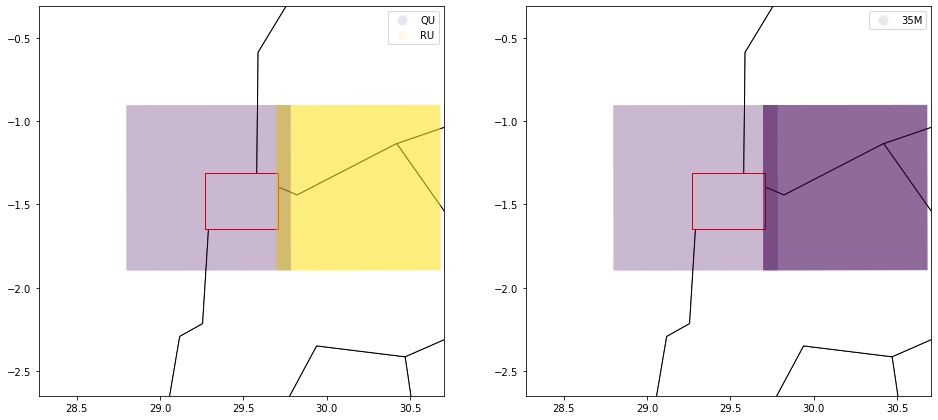

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import box, shape


items = list(search.items_as_dicts())
s2_list = [[i['id'], shape(i['geometry']), i['properties']['sentinel:grid_square'], str(i['properties']['sentinel:utm_zone']) + i['properties']['sentinel:latitude_band']] for i in items]
s2_list.append(['bounds', box(*bbox), ''])
s2_df = pd.DataFrame(s2_list, columns=["id", "polygon", "grid_square", "utm_zone"])

s2_gdf = gpd.GeoDataFrame(s2_df, geometry=s2_df.polygon)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# tiles colored by grid_square ID
base1 = world.plot(ax=ax1, color='white', edgecolor='black', figsize=(10, 10)) # AxesSubplot
s2_gdf[-1:].plot(ax=base1, color='white', edgecolor='red', alpha=1.0)
s2_gdf[:-1].plot(ax=base1, column='grid_square', cmap = "viridis", alpha=0.1, legend=True)

# tiles colored date
base2 = world.plot(ax=ax2, color='white', edgecolor='black', figsize=(10, 10))
s2_gdf[-1:].plot(ax=base2, color='white', edgecolor='red', alpha=1.0)
s2_gdf[:-1].plot(ax=base2, column='utm_zone', cmap = "viridis", alpha=0.1, legend=True)


minx, miny, maxx, maxy = s2_gdf[-1:].geometry.total_bounds
ax1.set_xlim(minx-1, maxx+1)
ax1.set_ylim(miny-1, maxy+1)

ax2.set_xlim(minx-1, maxx+1)
ax2.set_ylim(miny-1, maxy+1)

plt.show()

#### The code below calculates the area of the bounding box that is covered by the the item
#### We should probably use items that fully cover the target area

In [7]:
from functools import partial
import pyproj
from shapely.geometry import box, Point, Polygon, shape
from shapely.ops import transform
    

def reproject_shape(polygon, init_proj, target_proj):
    """
    EPSG: 4326, World Geodetic System 1984, degrees
    EPSG: 3857, Pseudo-Mercator / Google Maps, meters
    """
    reproject = partial(pyproj.transform, pyproj.Proj(init=init_proj), pyproj.Proj(init=target_proj))
    
    return transform(reproject, polygon)


def get_bbox_coverage(item, bbox):
    
    item_poly = shape(item["geometry"])
    bbox_poly = box(*bbox)
    
    # reproject to equal area so we get meters result
    item_poly = reproject_shape(item_poly, "epsg:4326", "epsg:3857")
    bbox_poly = reproject_shape(bbox_poly, "epsg:4326", "epsg:3857")
    
    intersection_poly = bbox_poly.intersection(item_poly)
    intersection_pct = (intersection_poly.area * 100) / bbox_poly.area

    return intersection_pct


### Download imagery

### Look into HTTP range request 
#### This would only download parts of the files we need

In [26]:
%%bash
# Accept-Ranges: bytes - tell us that server supports GET range requests
curl -I https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/35/M/QU/2022/8/S2A_35MQU_20220810_0_L2A/B01.tif

HTTP/1.1 200 OK
x-amz-id-2: 0oJC3/OpsaNiB8JtjBmQFq404AIny8QvfUYPZF3SIwDJAixZO9T478sTYFuUtdCREGCrMcwVw9U=
x-amz-request-id: ZD999RCSDMBX37KR
Date: Wed, 07 Dec 2022 21:04:50 GMT
Last-Modified: Wed, 10 Aug 2022 17:11:18 GMT
ETag: "b642884c379e966d97b7f0ce6342b93e"
Cache-Control: public, max-age=31536000, immutable
Accept-Ranges: bytes
Content-Type: image/tiff; application=geotiff; profile=cloud-optimized
Server: AmazonS3
Content-Length: 5715212



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0 5581k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


In [46]:
# let's try reading with GDAL
from osgeo import gdal
import numpy as np

# keys are required
gdal.SetConfigOption('AWS_SECRET_ACCESS_KEY', '')
gdal.SetConfigOption('AWS_ACCESS_KEY_ID', '')
gdal.SetConfigOption('AWS_NO_SIGN_REQUEST ', 'YES')

path = '/vsis3/sentinel-s2-l2a-cogs/35/M/QU/2022/8/S2A_35MQU_20220810_0_L2A/B02.tif'
actual_url = gdal.GetActualURL(path) # this only works if tokens present
print(actual_url)

# the rest of this isn't really working...
# removed aws tokens but they seem to be necessary
# https://gis.stackexchange.com/questions/201831/how-to-efficiently-access-files-with-gdal-from-an-s3-bucket-using-vsis3

/vsis3/sentinel-s2-l2a-cogs/35/M/QU/2022/8/S2A_35MQU_20220810_0_L2A/B02.tif


### This method uses rasterio Windows, which I think use HTTP Range requests to download bounding box only

In [16]:
import numpy as np
import numpy.ma as ma
from scipy.signal import convolve2d
from scipy.ndimage import binary_dilation

CLOUD_SCL_CLASSES = [0, 1, 2, 3, 8, 9, 10, 11]


def apply_cloud_mask(input_array, scl):
    
    mask = np.isin(scl, CLOUD_SCL_CLASSES)
    
    # this takes too long for large files
    if input_array.size < 10000000:
        kernel = np.ones((10, 10))
        mask = np.int64(convolve2d(mask, kernel, mode='same') > 0)
    
    masked_array = ma.masked_array(input_array, mask=mask)
    return masked_array

In [17]:
%%time

import matplotlib.pyplot as plt
import os
from osgeo import gdal
import rasterio
from rasterio.plot import show
from shapely.geometry import box, shape
import time # TESTING
   
if not os.path.exists(s2_dir):
    os.makedirs(s2_dir)
    os.mkdir(f'{s2_dir}/composites/')
    
bbox_poly = box(*bbox)
bbox_poly_ea = reproject_shape(bbox_poly, "epsg:4326", "epsg:3857")


for item in list(collection):
    print()
    print(item.id)
    print(item.properties["sentinel:grid_square"], "-", str(item.properties['sentinel:utm_zone']) + item.properties["sentinel:latitude_band"])
    
    band_hrefs = [item.assets[band].href for band in bands]
    #image_hrefs = [item.assets[key].href for key in item.assets if key in bands]
    
    # reproject bounding box into projection of Sentinel scene
    item_epsg = f'epsg:{item.properties["proj:epsg"]}'
    bbox_sw = reproject_shape(Point(bbox[0], bbox[1]), init_proj="epsg:4326", target_proj=item_epsg)
    bbox_ne = reproject_shape(Point(bbox[2], bbox[3]), init_proj="epsg:4326", target_proj=item_epsg)
    
    # calculate intersection between Sentinel scene and bounding box
    # so that we can save data properly to tif
    scene_poly = shape(item.geometry)
    overlap_poly = bbox_poly.intersection(scene_poly)
    overlap_poly_ea = reproject_shape(overlap_poly, "epsg:4326", "epsg:3857")            

    overlap_bbox = overlap_poly.bounds # lat/lng
    overlap_sw = reproject_shape(Point(overlap_bbox[0], overlap_bbox[1]), init_proj="epsg:4326", target_proj=item_epsg)
    overlap_ne = reproject_shape(Point(overlap_bbox[2], overlap_bbox[3]), init_proj="epsg:4326", target_proj=item_epsg)
        
    if not os.path.exists(f'{s2_dir}/{item.id}'):
        os.mkdir(f'{s2_dir}/{item.id}')
            
    for href in band_hrefs:
        band_name = href.split('/')[-1].split('.')[0]
        file_path = f'{s2_dir}/{item.id}/{band_name}.tif'
        
        if not os.path.exists(file_path):
            
            with rasterio.open(href) as src:
                
                # create window and only read data from the window, rather than entire file
                window = rasterio.windows.from_bounds(bbox_sw.x, bbox_sw.y, bbox_ne.x, bbox_ne.y, src.transform)
                data = src.read(1, window=window)
                height, width = data.shape[0], data.shape[1]
                print(f'\t{band_name}... rows: {height}, cols: {width}')
                
                # applying the cloud mask here is weird because the SCL is not yet aligned with the other bands
                
                new_transform = rasterio.transform.from_bounds(overlap_sw.x, overlap_sw.y, overlap_ne.x, overlap_ne.y, width, height)
                kwargs = {
                    "mode": "w",
                    "driver": "GTiff",
                    "height": height,
                    "width": width,
                    "count": 1,
                    "dtype": data.dtype,
                    "crs": src.crs,
                    "transform": new_transform
                }
                    
                with rasterio.open(file_path,  **kwargs) as new_src:
                    new_src.write(data, 1) 
        
            # convert all to Web Mercator so that files can be combined, and can reference resolution (xRes, yRes) in meters 
            gdal.Warp(file_path, file_path, dstSRS="EPSG:3857", xRes=10, yRes=10, outputBounds=overlap_poly_ea.bounds) 
            


S2A_35MRU_20220810_1_L2A
RU - 35M
	SCL... rows: 1856, cols: 55
	B02... rows: 3712, cols: 110
	B03... rows: 3712, cols: 110
	B04... rows: 3712, cols: 110
	B08... rows: 3712, cols: 110

S2B_35MRU_20220805_0_L2A
RU - 35M
	SCL... rows: 1856, cols: 55
	B02... rows: 3712, cols: 110
	B03... rows: 3712, cols: 110
	B04... rows: 3712, cols: 110
	B08... rows: 3712, cols: 110

S2A_35MRU_20220721_0_L2A
RU - 35M
	SCL... rows: 1856, cols: 55
	B02... rows: 3712, cols: 110
	B03... rows: 3712, cols: 110
	B04... rows: 3712, cols: 110
	B08... rows: 3712, cols: 110

S2A_35MRU_20220711_0_L2A
RU - 35M
	SCL... rows: 1856, cols: 55
	B02... rows: 3712, cols: 110
	B03... rows: 3712, cols: 110
	B04... rows: 3712, cols: 110
	B08... rows: 3712, cols: 110

S2B_35MRU_20220706_0_L2A
RU - 35M
	SCL... rows: 1856, cols: 55
	B02... rows: 3712, cols: 110
	B03... rows: 3712, cols: 110
	B04... rows: 3712, cols: 110
	B08... rows: 3712, cols: 110

S2A_35MQU_20220112_0_L2A
QU - 35M
	SCL... rows: 1856, cols: 2423
	B02... rows: 

## Apply Cloud Mask

In [18]:
%%time

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
from rasterio.plot import show


for band in bands:
    if band == "SCL":
        continue
        
    print(band)
        
    band_files = glob.glob(f'{s2_dir}/*/*{band}.tif')

    for file_path in band_files:
        
        masked_file = file_path.replace('.tif', '_masked.tif')
        #if os.path.exists(masked_file):
        #    continue
        
        # get the SCL file for that scene
        scl_path = file_path.replace(band, "SCL")
        with rasterio.open(scl_path) as scl_src:
            scl_data = scl_src.read(1)

        with rasterio.open(file_path) as band_src:
            print('\t' + str(band_src.height * band_src.width / 1e6) + f' - {file_path}')
            
            band_data = band_src.read(1)
            masked_data = apply_cloud_mask(band_data, scl_data) # MaskedArray
            #zeroed_data = masked_data.data * ~masked_data.mask  # ndarray (zeroes for masked)
            
            zeroed_data = masked_data.data
            zeroed_data[masked_data.mask] = nodata # can't use negatives because dtype = uint16
            
            with rasterio.open(masked_file, "w", **band_src.profile) as masked_src:
                masked_src.write(zeroed_data, 1)
                

B02
	0.407878 - data/s2/S2B_35MRU_20220805_0_L2A/B02.tif
	0.407878 - data/s2/S2A_35MRU_20210825_0_L2A/B02.tif
	0.407878 - data/s2/S2B_35MRU_20210731_0_L2A/B02.tif
	0.407878 - data/s2/S2A_35MRU_20220810_1_L2A/B02.tif
	18.115022 - data/s2/S2A_35MQU_20220112_0_L2A/B02.tif
	18.115022 - data/s2/S2A_35MQU_20210825_0_L2A/B02.tif
	0.407878 - data/s2/S2A_35MRU_20220112_0_L2A/B02.tif
	18.115022 - data/s2/S2A_35MQU_20211123_0_L2A/B02.tif
	0.407878 - data/s2/S2A_35MRU_20220711_0_L2A/B02.tif
	0.407878 - data/s2/S2B_35MRU_20220706_0_L2A/B02.tif
	0.407878 - data/s2/S2A_35MRU_20220721_0_L2A/B02.tif
B03
	0.407878 - data/s2/S2B_35MRU_20220805_0_L2A/B03.tif
	0.407878 - data/s2/S2A_35MRU_20210825_0_L2A/B03.tif
	0.407878 - data/s2/S2B_35MRU_20210731_0_L2A/B03.tif
	0.407878 - data/s2/S2A_35MRU_20220810_1_L2A/B03.tif
	18.115022 - data/s2/S2A_35MQU_20220112_0_L2A/B03.tif
	18.115022 - data/s2/S2A_35MQU_20210825_0_L2A/B03.tif
	0.407878 - data/s2/S2A_35MRU_20220112_0_L2A/B03.tif
	18.115022 - data/s2/S2A_35MQU_20

In [ ]:
import matplotlib.pyplot as plt
import numpy.ma as ma
import rasterio

test_href = "data/s2/S2A_35MRU_20220721_0_L2A/B08_masked.tif"
#test_href = "data/s2/S2A_35MRU_20220112_0_L2A/B08.tif"

    
with rasterio.open(test_href) as src:
    data = src.read(1)
    data = ma.masked_array(data, mask=data==nodata)
        
    plt.imshow(data)

B02
(3742, 4842)


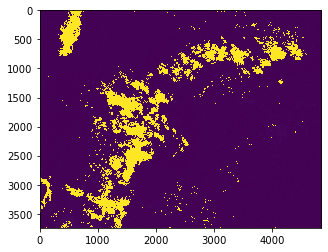

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy.ma as ma

import rasterio
import rasterio.merge

s2_dir = 'data/s2'
bands = ['SCL', 'B02', 'B03', 'B04', 'B08'] # make sure SCL first
nodata = 65534

for band in bands:
    if band == "SCL":
        continue
    
    print(band)

    band_files = glob.glob(f'{s2_dir}/*/*{band}_masked.tif')
    band_ds = [rasterio.open(fp) for fp in band_files]
    
    left, bottom, right, top = -1, -1, -1, -1
    
    for ds in band_ds:
        bounds = ds.bounds
        
        if bounds.left < left or left < 0:
            left = bounds.left
            
        if bounds.bottom < bottom or bottom < 0:
            bottom = bounds.bottom
            
        if bounds.right > right or right < 0:
            right = bounds.right
            
        if bounds.top > top or top < 0:
            top = bounds.top
            
    
    merged, transform = rasterio.merge.merge(band_ds[6:], nodata=nodata, bounds=(left, bottom, right, top))
    merged = merged[0, :, :]
    print(merged.shape)
    
    masked = ma.masked_array(merged, mask=merged==nodata)
    plt.imshow(masked)
    plt.show()
    break


### This is the old method that downloads everything first. It's much slower.

In [62]:
%%time

import os
from osgeo import gdal
import urllib.request
import xarray as xr

# /shared_space/G1/s2
for item in list(collection):
    print(item.id)
    images = [item.assets[key].href for key in item.assets if key.startswith("B") or key == "SCL"]
    
    if not os.path.exists(f'/shared_space/G1/s2/{item.id}'):
        os.mkdir(f'/shared_space/G1/s2/{item.id}')
        
    for href in images:
        filename = href.split('/')[-1].split('.')[0]
        original_path = f'/shared_space/G1/s2/{item.id}/{filename}.tif'
        cropped_path = f'/shared_space/G1/s2/{item.id}/{filename}_cropped.tif'
        
        if not os.path.exists(original_path):
            #print(f'\tdownloading: {filename}')
            urllib.request.urlretrieve(href, f'/shared_space/G1/s2/{item.id}/{filename}.tif')
        
        if not os.path.exists(cropped_path):
            #print(f'\tcropping: {filename}')
            gdal.Warp(cropped_path, original_path, dstSRS="EPSG:4326", outputBounds=bbox)

S2A_35MQU_20220810_0_L2A
S2B_35MQU_20220805_0_L2A
S2A_35MQU_20220721_0_L2A
S2B_35MQU_20220706_0_L2A
S2A_35MQU_20220112_0_L2A
S2A_35MQU_20211123_0_L2A
S2B_35MQU_20211108_0_L2A


KeyboardInterrupt: 

#### Visualize the results after first converting items and bbox to a GeoPandas DataFrame
#### This is not working right now because the right holoviews packages aren't installed correctly